# Analyzing Iowa Liquor Sales

## Data Set 

The state of Iowa's Alcoholic Beverages Division [dataset](https://data.iowa.gov/Economy/Iowa-Liquor-Sales/m3tr-qhgy  ) consists of spirit purchase information from January 1, 2012 to current. 

> The Division can provide this level of information because Iowa is one of 17 states that directly controls the sale and distribution of alcoholic beverages https://abd.iowa.gov/division. 

It should be noted that the data set is limited to Iowa Class “E” liquor license which is for:  

> Grocery stores, liquor stores, convenience stores, etc. Allows commercial establishments to sell liquor for off-premises consumption in original unopened containers. No sales by the drink.

Also, while this data set is not direct consumer sales, we can use this information as a proxy indicator of sales because most stores should be only buying spirits that sell well in their stores.  

### Adding the Data Set to MongoDB

I am assuming you have already installed MongoDB but if you haven't you will need to navigate to [MongoDB](https://www.mongodb.org/)  and download the latest version. After installation of MongoDB you will need to follow the next steps and open a connection.

After installation.

Open a command prompt window in the `bin` folder from your `MongoDB` installation and type `mongod`.

![](https://raw.githubusercontent.com/ChristopheHunt/MSDA---Coursework/master/Data%20607/Homework/Project%204/mongod.JPG)

Then in a new command prompt window in the same `bin` folder type `mongo` and continue to create our new collection.

![](https://raw.githubusercontent.com/ChristopheHunt/MSDA---Coursework/master/Data%20607/Homework/Project%204/mongo.JPG)

In [1]:
from pymongo import MongoClient

client = MongoClient()
db = client.test
liquor = db.iowaliquor
liquor.delete_many({})

In [2]:
import numpy as np
import pandas as pd
import datetime
import urllib
import matplotlib

#### If you don't already have a code you will need one from Socrata to pull down the Iowa Data set. The API key can be found at  https://www.socrata.com/


In [3]:
from sodapy import Socrata
client = Socrata("data.iowa.gov", "ibhJMpvP9MQ1Rl0Ox5wlSMpgn")
results = client.get("spsw-4jax", limit = 1000000)
added_results = liquor.insert_many(results)
added_results

In [4]:
list = []
for liquors in liquor.find():
    list.append(liquors)

In [5]:
df = pd.DataFrame(list)
df.columns = ['_id', 'address', 'bottle_volume_ml', 'category', 'category_name',
       'city', 'county', 'county_number', 'date', 'im_desc',
       'invoice_line_no', 'itemno', 'name', 'pack', 'sale_bottles',
       'sale_dollars', 'sale_gallons', 'sale_liters', 'state_bottle_cost',
       'state_bottle_retail', 'store', 'store_location',
       'store_location_address', 'store_location_city',
       'store_location_zip', 'vendor_name', 'vendor_no', 'zipcode']

df['state_bottle_cost'] = df['state_bottle_cost'].astype('float64')
df['bottle_volume_ml'] = df['bottle_volume_ml'].astype('float64')
df['sale_dollars'] = df['sale_dollars'].astype('float64')
df['sale_gallons'] = df['sale_gallons'].astype('float64')

In [6]:
column_subset = df[['category_name', 'county', 'bottle_volume_ml']]
grouped = column_subset.groupby('category_name')
grouped = pd.DataFrame(grouped.sum())
results = grouped.sort_values(by = 'bottle_volume_ml', ascending = False)
results.columns = ['Total Bottle Volume (in ml)']
results.head(10)

,Total Bottle Volume (in ml)
category_name,
VODKA 80 PROOF,139310850.0
CANADIAN WHISKIES,93842128.0
STRAIGHT BOURBON WHISKIES,53103500.0
SPICED RUM,52175350.0
BLENDED WHISKIES,49012827.0
AMERICAN COCKTAILS,48388100.0
PUERTO RICO & VIRGIN ISLANDS RUM,44540900.0
VODKA FLAVORED,41494404.0
IMPORTED VODKA,37490725.0


### Interestingly, we see that Vodka 80 proof and Canadian Whiskies sell at large volumes. I am curious how this translates to the cost of this liquor. I would assume that these are the cheaper liquors which are being sold at high volumes based on personal experience in stores. I typically see the cheaper liquors being sold in large bottles versus the more expensive liquors being sold at smaller volumes  

In [7]:
column_subset = df[['category_name', 'sale_dollars', 'sale_gallons']]
grouped = column_subset.groupby('category_name')
grouped = pd.DataFrame(grouped.sum())
results = pd.DataFrame(grouped.sort_values(by = 'sale_dollars', ascending = False))
results = pd.DataFrame(results['sale_dollars'] / results['sale_gallons'])
results.columns = ['Sale per gallon sold']
results = results.sort_values(by = 'Sale per gallon sold', ascending = True)
results.head(10)

,Sale per gallon sold
category_name,
TRIPLE SEC,15.719525
AMERICAN AMARETTO,26.452779
AMERICAN COCKTAILS,26.988900
SPEARMINT SCHNAPPS,27.646909
100 PROOF VODKA,29.543432
PEPPERMINT SCHNAPPS,29.995041
TROPICAL FRUIT SCHNAPPS,30.485252
VODKA 80 PROOF,30.544185
AMERICAN SLOE GINS,31.638868


### It appears that our top volume sales are not necessarily the cheapest available liquors. While the top liquors by volume are Vodka 80 proof and Canadian Whiskies, we see more mixer type liquors being sold at lower prices per gallon. However, since we do see that Vodka 80 Proof is the most sold liquor by volume and is in the top 10 of cheapest liquors sold in Iowa. Let's explore the sales of Vodka 80 Proof more to see if there are any interesting patterns. 

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
import matplotlib.mlab as mlab
import numpy as np

In [10]:
client = MongoClient()
db = client.test
liquor = db.iowaliquor
liquor.delete_many({})

from sodapy import Socrata

client = Socrata("data.iowa.gov", "ibhJMpvP9MQ1Rl0Ox5wlSMpgn")
results = client.get("spsw-4jax", where="category='1031080'", limit = 1000000)
added_results = liquor.insert_many(results)

#### We us "where="category='1031080'"" because 1031080 is the Category ID for Vodka 80 Proof

In [11]:
list = []
for liquors in liquor.find():
    list.append(liquors)

In [12]:
df = pd.DataFrame(list)
df.columns = ['_id', 'address', 'bottle_volume_ml', 'category', 'category_name',
       'city', 'county', 'county_number', 'date', 'im_desc',
       'invoice_line_no', 'itemno', 'name', 'pack', 'sale_bottles',
       'sale_dollars', 'sale_gallons', 'sale_liters', 'state_bottle_cost',
       'state_bottle_retail', 'store', 'store_location',
       'store_location_address', 'store_location_city',
       'store_location_zip', 'vendor_name', 'vendor_no', 'zipcode']

df['state_bottle_cost'] = df['state_bottle_cost'].astype('float64')
df['bottle_volume_ml'] = df['bottle_volume_ml'].astype('float64')
df['sale_dollars'] = df['sale_dollars'].astype('float64')
df['sale_gallons'] = df['sale_gallons'].astype('float64')
df['date'] = pd.to_datetime(df['date'])

In [13]:
top_n_countries = 5
top_counties = df[['county', 'sale_gallons']]
top_counties = top_counties.groupby(["county"]).sum().sort_values(\
                                      by = 'sale_gallons', ascending = False).head(\
                                      top_n_countries).index.values.tolist()
pd.DataFrame(top_counties)

,0
0,Polk
1,Linn
2,Scott
3,Johnson
4,Black Hawk


#### We will look at the top 5 counties and the volume of VODKA 80 PROOF sales over the time period of the data set. Polk County is a the top of our list but that should not be suprising as that is the largest county by population in Iowa. 

In [14]:
vodka_column_subset = df[['sale_gallons', 'county', 'date']]
vodka_column_subset = vodka_column_subset[vodka_column_subset['county'].isin(top_counties)]
vodka_column_subset['date'] =  pd.to_datetime(vodka_column_subset['date'], format = "%m/%d/%Y")
vodka_column_subset = vodka_column_subset.set_index('date')
grouped = vodka_column_subset.groupby(["county", pd.TimeGrouper('M')]).sum()
grouped.head(10)

sale_gallons
county     date                    
Black Hawk 2012-01-31   3355.189798
           2012-02-29   3256.316803
           2012-03-31   3577.662292
           2012-04-30   3941.321539
           2012-05-31   4275.756753
           2012-06-30   4308.586735
           2012-07-31   4190.039527
           2012-08-31   4396.047497
           2012-09-30   3401.862396
           2012-10-31   6504.906574

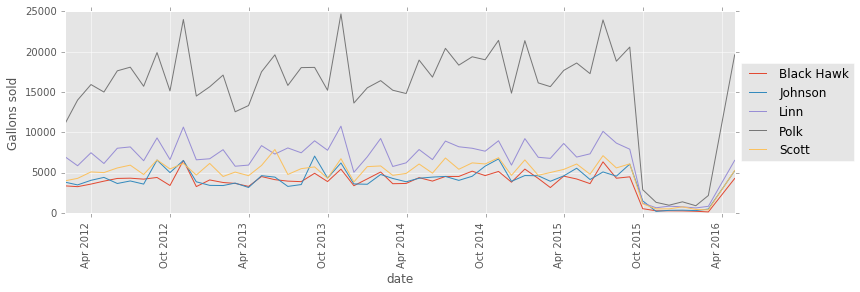

In [17]:
plotting = grouped.unstack().fillna(0).transpose().unstack(level=0)
plotting.columns = plotting.columns.droplevel(1)

fig = plt.figure()
ax = plotting.unstack().fillna(0).transpose().unstack(level=0).plot()

#legend help from http://stackoverflow.com/questions/4700614/how-to-put-the-legend-out-of-the-plot
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 2, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks(rotation='vertical')
plt.xlabel("date")
plt.ylabel("Gallons sold")

plt.show()

##### I found that creating a thematic map with Python is very non-trivial. A lot of assistance in producing the below code was made possible by http://cimms.ou.edu/~lakshman/spatialprogramming/chapter03_basicgis/ch03_basicgis.pdf and http://brandonrose.org/pythonmap. The below thematic mapping is a derivative of the work of the two resources. 

In [18]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from matplotlib.collections import PatchCollection
from mpl_toolkits.basemap import Basemap
from shapely.geometry import Point, Polygon, MultiPoint, MultiPolygon
from shapely.prepared import prep
from pysal.esda.mapclassify import Natural_Breaks as nb
from descartes import PolygonPatch
import fiona
from itertools import chain
import pysal.esda.mapclassify as mapclassify
import sys, shutil, os, shapefile as shp

In [19]:
sf = shp.Reader(".//cb_2015_us_county_20m/cb_2015_us_county_20m");
shapes = sf.shapes()
fields = sf.fields
records = sf.records()

def find_column(column_name):
    for i in range(len(sf.fields)):
        if(sf.fields[i][0] == column_name):
            return i - 1
    sys.exit(-1)

NAME = find_column('STATEFP')

iowa = shp.Writer(shp.POLYGON)
iowa.fields = sf.fields
for shapeno in range(len(shapes)):
    shapename = records[shapeno][NAME]
    if (shapename == '19'): #19 is the state code for Iowa
        iowa.records.append(records[shapeno])
        iowa.shapes().append(shapes[shapeno])

outputdir = "..//Final Project//New File";
shutil.rmtree(outputdir, ignore_errors=True)
os.mkdir(outputdir)
filename = (outputdir + "//iowa")
iowa.save(filename)
shutil.copyfile(".//cb_2015_us_county_20m/cb_2015_us_county_20m.prj", \
               filename + ".prj");

#### The above code takes the county information from the census bureau and subsets out the counties for Iowa. Now lets map it so we can see if we subsetted the Iowa map appropriately. 


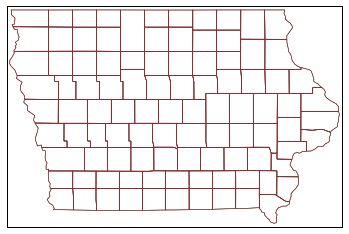

In [20]:
from mpl_toolkits.basemap import Basemap
import numpy as np
import shapefile as shp
import matplotlib.pyplot as plt

def find_bounding_box(shpfile):
    shapes = shp.Reader(shpfile).shapes()
    bbox = [180, 90, -180, -90]
    for shape in shapes:
        bbox[0] = min(bbox[0], shape.bbox[0])
        bbox[1] = min(bbox[1], shape.bbox[1])
        bbox[2] = max(bbox[2], shape.bbox[2])
        bbox[3] = max(bbox[3], shape.bbox[3])
    bbox[0] -= 0.05
    bbox[1] -= 0.05
    bbox[2] += 0.05
    bbox[3] += 0.05
    return bbox

bbox = find_bounding_box(".//New File//iowa")

m = Basemap(projection='merc',\
            llcrnrlat=bbox[1],\
            urcrnrlat=bbox[3],\
            llcrnrlon=bbox[0],\
            urcrnrlon=bbox[2],\
            lat_ts=20,resolution='c')


countyshp = m.readshapefile(".//New File//iowa", \
                            "counties", drawbounds=True)
for shape in m.counties:
    xx,yy = zip(*shape)
    m.plot(xx,yy,linewidth=.5, color = 'brown')
    
m.drawmapboundary(fill_color = 'w')
plt.show()

#### Now that we have the county map of Iowa, we can begin thematic mapping. I relied on http://brandonrose.org/pythonmap to develop the thematic map and the below code is a derivative of Brandon's work. 

In [21]:
from shapely.geometry import Point, Polygon, MultiPoint, MultiPolygon
# set up a map dataframe
df_map = pd.DataFrame({'poly': [Polygon(xy) for xy in m.counties],'county': [county['NAME'] for county in m.counties_info]})

vodka_column_subset = df[['sale_gallons', 'county']]
pd.options.display.multi_sparse = False
grouped = vodka_column_subset.groupby(["county"]).sum().dropna().reset_index()
df_map = pd.merge(grouped, df_map, on='county')

#### The below functions are for working with color ramps and bars, this will allow us to create the necessary heat map. 

In [22]:
# Convenience functions for working with color ramps and bars
def colorbar_index(ncolors, cmap, labels=None, **kwargs):
    """
    This is a convenience function to stop you making off-by-one errors
    Takes a standard colour ramp, and discretizes it,
    then draws a colour bar with correctly aligned labels
    """
    cmap = cmap_discretize(cmap, ncolors)
    mappable = cm.ScalarMappable(cmap=cmap)
    mappable.set_array([])
    mappable.set_clim(-0.5, ncolors+0.5)
    colorbar = plt.colorbar(mappable, **kwargs)
    colorbar.set_ticks(np.linspace(0, ncolors, ncolors))
    colorbar.set_ticklabels(range(ncolors))
    if labels:
        colorbar.set_ticklabels(labels)
    return colorbar

def cmap_discretize(cmap, N):
    """
    Return a discrete colormap from the continuous colormap cmap.

        cmap: colormap instance, eg. cm.jet. 
        N: number of colors.

    Example
        x = resize(arange(100), (5,100))
        djet = cmap_discretize(cm.jet, 5)
        imshow(x, cmap=djet)

    """
    if type(cmap) == str:
        cmap = get_cmap(cmap)
    colors_i = np.concatenate((np.linspace(0, 1., N), (0., 0., 0., 0.)))
    colors_rgba = cmap(colors_i)
    indices = np.linspace(0, 1., N + 1)
    cdict = {}
    for ki, key in enumerate(('red', 'green', 'blue')):
        cdict[key] = [(indices[i], colors_rgba[i - 1, ki], colors_rgba[i, ki]) for i in range(N + 1)]
    return matplotlib.colors.LinearSegmentedColormap(cmap.name + "_%d" % N, cdict, 1024)

In [23]:
var_2_analyze = 'sale_gallons'

jenks = True

if jenks == True:
    breaks = nb(
        df_map[df_map[var_2_analyze].notnull()][var_2_analyze].values,
        initial=300,
        k=10)

if 'bins' in df_map.columns:
    df_map = df_map.drop('bins',1)

b = pd.DataFrame({'bins': breaks.yb}, index=df_map[df_map[var_2_analyze].notnull()].index)
df_map = df_map.join(b)
df_map.bins.fillna(-1, inplace=True)

if jenks == True:
    bin_labels = ["<= %0.0f" % b for b in breaks.bins]

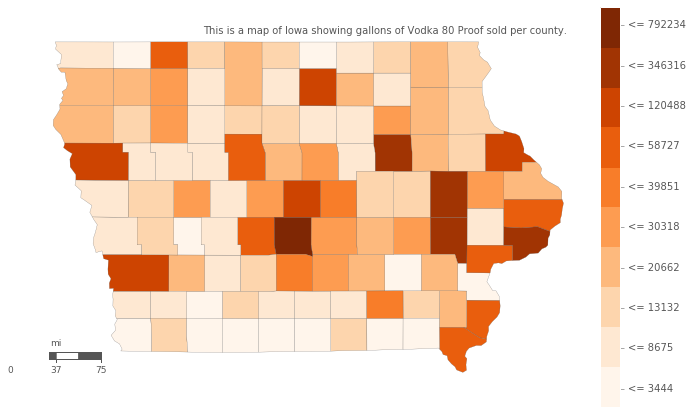

In [24]:
plt.clf()
fig = plt.figure(facecolor='white')
ax = fig.add_subplot(111, axisbg='w', frame_on=False)

# use a blue colour ramp ('Blues') - we'll be converting it to a map using cmap()
# you could also use 'Oranges' or 'Greens' 
cmap = plt.get_cmap('Oranges')

df_map['patches'] = df_map['poly'].map(lambda x: PolygonPatch(x, ec='#555555', lw=.2, alpha=1., zorder=4))


smallprint = ax.text(
    # set the x,y location of the smallprint
    1, 1,
    'This is a map of Iowa showing gallons of Vodka 80 Proof sold per county.',
    ha='right', va='bottom',
    size=10,
    color='#555555',
    transform=ax.transAxes)

pc = PatchCollection(df_map['patches'], match_original=True)

norm = Normalize(vmin=df_map['bins'].min(), vmax=df_map['bins'].max())

pc.set_facecolor(cmap(norm(df_map['bins'].values)))
ax.add_collection(pc)

cb = colorbar_index(ncolors=len(bin_labels), cmap=cmap, shrink=0.5, labels=bin_labels)
cb.ax.tick_params(labelsize=10)

m.drawmapscale(
    bbox[0] + 0.08, bbox[1] + 0.215,
    bbox[0], bbox[1],
    75.,
    barstyle='fancy', labelstyle='simple',
    fillcolor1='w', fillcolor2='#555555',
    fontcolor='#555555',
    zorder=5,
    units='mi')

plt.tight_layout()
fig.set_size_inches(10,12)
plt.savefig('iowa_' + var_2_analyze + '.png', dpi=1000, alpha=True)

# display our plot
plt.show()

#### As we can see the higher gallon sales are in some of the most populous counties. One interesting outlier is Dickinson county in the top left hand coner of the state that is in the <=58727 category. More research is needed to understand why this rate is so high especially considering that the county has a population of only 16,667. 